In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns

## Load the dataset

In [3]:
df = pd.read_csv('../data/raw/srcsc-2025-dam-data-for-students.csv')

## Rename features

In [4]:
def general_rename(str):
    return str.lower().replace(' ', '_')

In [5]:
renamed_df = df.rename(columns=general_rename).rename(columns={
    'height_(m)': 'height',
    'length_(km)': 'length',
    'volume_(m3)': 'volume',
    'surface_(km2)': 'surface',
    'drainage_(km2)': 'drainage',
    'distance_to_nearest_city_(km)': 'distance_to_nearest_city',
    'loss_given_failure_-_prop_(qm)': 'dam_repair_loss',
    'loss_given_failure_-_liab_(qm)': 'damage_loss',
    'loss_given_failure_-_bi_(qm)': 'business_interruption_loss'
})

## Feature Engineering

#### years_completed

In [6]:
# calculate the dam age
renamed_df['age'] = 2025 - renamed_df['year_completed']

#### years_modified

In [7]:
#calculate the length of given list
def list_len(list):
    if list == 0:
        return 0
    return len(set(list))

modification_pattern = r'(\d{4})'
# count the number of unique modifications
renamed_df['modify_count'] = renamed_df['years_modified'].str.findall(pat=modification_pattern).fillna(0).apply(list_len)

In [8]:
# convert all elements in the list to integer and calcualte the difference between 2025 and max value in the list
def years_from_cal(list):
    if list == -1:
        return list
    list = [int(i) for i in list]
    list.sort()
    return 2025 - list[-1]

# calculate the years taken from last modification
renamed_df['years_from_modification'] = renamed_df['years_modified'].str.findall(modification_pattern).fillna(-1).apply(years_from_cal)
# fill null value with dam age
renamed_df['years_from_modification'] = renamed_df['years_from_modification'].where(cond=renamed_df['years_from_modification'] != -1, other=renamed_df['age'])


#### last_inspection_date

In [9]:
# Calculate the years taken from last inspection
renamed_df['years_from_inspection'] = renamed_df['last_inspection_date'].str.findall(r'\d{2}/\d{2}/(\d{4})').fillna(-1).apply(years_from_cal)
# fill null value with the dam age
renamed_df['years_from_inspection'] = renamed_df['years_from_inspection'].where(cond=renamed_df['years_from_inspection'] != -1, other=renamed_df['age'])


#### inspection_frequency

In [10]:
# fill na with mode category: 0
renamed_df['inspection_frequency'] = renamed_df['inspection_frequency'].fillna(0)
renamed_df['inspection_frequency'] = renamed_df['inspection_frequency'].apply(lambda x: 1/x if x != 0 else 0)

#### assessment_date

In [11]:
# Calculate the years taken from last inspection
renamed_df['years_from_assessment'] = renamed_df['assessment_date'].str.findall(r'\d{2}/\d{2}/(\d{4})').fillna(-1).apply(years_from_cal)
# fill null value with the dam age
renamed_df['years_from_assessment'] = renamed_df['years_from_assessment'].where(cond=renamed_df['years_from_assessment'] != -1, other=renamed_df['age'])


In [12]:
# drop used features
engineered_df = renamed_df.drop(columns=['years_modified', 'last_inspection_date', 'year_completed', 'assessment_date'])

## Impute outliers

In [13]:
# impute outliers with median of outlier-removed dataframe
def impute_outliers(df, feature):
    # calculate IQR
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    # calculate median without outliers
    removed_df = df[(df[feature] >= lower) & (df[feature] <= upper)]
    new_median = removed_df[feature].median()
    # impute outliers with median calculated
    df.loc[(df[feature] < lower) | (df[feature] > upper), feature] = new_median
    return

In [14]:
for feature in ['length', 'volume', 'surface', 'drainage']:
    engineered_df[feature] = engineered_df[feature].replace(0, np.nan)

# impute outliers with median
for feature in ['length', 'volume', 'surface', 'drainage']:
    impute_outliers(engineered_df, feature)
outliers_imputed_df = engineered_df

## Handle Missing Data

In [15]:
for feature in outliers_imputed_df.columns:
    if engineered_df[feature].isna().sum() > 0:
        print(f'{feature} : {outliers_imputed_df[feature].isna().sum()}  {round(outliers_imputed_df[feature].isna().sum()/len(outliers_imputed_df)*100, 2)}%')


primary_purpose : 1184  5.69%
primary_type : 257  1.24%
length : 2925  14.06%
volume : 12838  61.7%
surface : 4668  22.44%
drainage : 7671  36.87%
spillway : 12786  61.45%
distance_to_nearest_city : 10229  49.16%
assessment : 2537  12.19%
dam_repair_loss : 7  0.03%
damage_loss : 12  0.06%
business_interruption_loss : 10730  51.57%
age : 1384  6.65%
years_from_modification : 1284  6.17%
years_from_inspection : 659  3.17%
years_from_assessment : 785  3.77%


#### numerical features

In [16]:
for feature in ['length', 'volume', 'surface', 'drainage', 'distance_to_nearest_city', 'age', 'years_from_modification', 'years_from_inspection', 'years_from_assessment']:
    outliers_imputed_df[feature] = outliers_imputed_df[feature].fillna(outliers_imputed_df[feature].median())

#### categorical_feature

In [17]:
# fill null with NA
for feature in ['primary_purpose', 'spillway']:
    outliers_imputed_df[feature] = outliers_imputed_df[feature].fillna('NA')

# fill null with mode category
for feature in ['primary_type', 'assessment']:
    outliers_imputed_df[feature] = outliers_imputed_df[feature].fillna(outliers_imputed_df[feature].mode()[0])

In [18]:
outliers_imputed_df

,id,region,regulated_dam,primary_purpose,primary_type,height,length,volume,surface,drainage,...,assessment,probability_of_failure,dam_repair_loss,damage_loss,business_interruption_loss,age,modify_count,years_from_modification,years_from_inspection,years_from_assessment
0,SOAD00072,Navaldia,Yes,Recreation,Earth,0.000,0.195,26000.0,0.02364,2.66329,...,Satisfactory,0.1258,20.8,296.9,8.1,61.0,0,59.0,10.0,11.0
1,SOAD00380,Navaldia,No,NA,Earth,2.713,0.195,26000.0,0.09456,39.94935,...,Not Available,0.0757,930.5,727.5,NaN,98.0,0,98.0,7.0,98.0
2,SOAD00610,Navaldia,Yes,Recreation,Earth,0.000,0.195,26000.0,0.09456,39.94935,...,Satisfactory,0.1375,355.5,427.3,8.6,61.0,0,59.0,34.0,11.0
3,SOAD00862,Navaldia,Yes,NA,Earth,0.000,0.195,26000.0,0.09456,39.94935,...,Not Rated,0.1403,295.1,25.3,NaN,61.0,0,59.0,34.0,11.0
4,SOAD02091,Lyndrassia,Yes,Recreation,Earth,13.921,0.200,26000.0,0.04728,39.94935,...,Not Rated,0.0998,11.5,203.0,5.6,44.0,0,44.0,4.0,44.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20801,SOAD16536,Lyndrassia,No,Flood Risk Reduction,Rockfill,35.872,0.195,26000.0,0.09456,39.94935,...,Not Available,0.0837,820.9,510.6,NaN,47.0,0,47.0,2.0,47.0
20802,SOAD13145,Lyndrassia,No,Hydroelectric,Gravity,141.296,0.195,26000.0,0.09456,39.94935,...,Not Available,0.0795,850.2,176.6,62.9,52.0,0,52.0,5.0,52.0
20803,SOAD12688,Navaldia,No,Flood Risk Reduction,Earth,37.905,0.195,26000.0,0.09456,39.94935,...,Not Available,0.0972,922.4,490.6,NaN,71.0,0,71.0,3.0,71.0
20804,SOAD02340,Navaldia,No,Flood Risk Reduction,Earth,46.431,0.195,26000.0,0.09456,39.94935,...,Not Available,0.0672,652.4,603.7,NaN,60.0,0,60.0,4.0,60.0


### Visualisation

In [19]:
def null_dropped_mean_plot(target_feature):
    mean_list = []
    null_feature_list = data.drop(columns=data.columns[data.isna().sum() == 0]).columns
    for null_feature in null_feature_list:
    # the mean value for target feature if null feature is dropped
        current_mean = data[data[null_feature].isna()].describe()[target_feature].loc['mean']
        mean_list.append(current_mean)
    plt.figure(figsize=(40,10))
    plt.bar(x=null_feature_list, height=mean_list, align='center', width=0.5)
    plt.xlabel('Null Feature')
    plt.ylabel(f'{target_feature} Mean')



In [20]:
null_dropped_mean_plot('Distance to Nearest City (km)')

NameError: name 'data' is not defined

In [21]:
plt.figure(figsize=(40,40))
position =np.arange(len(data.describe().loc['mean'].drop('Volume (m3)')))
width = 0.3
plt.bar(x=position - width/2, 
        height=list(data.describe().loc['mean'].drop('Volume (m3)')), 
        align='center',
        width=width)
plt.bar(x=position + width/2, 
        height=list(data[data['Volume (m3)'].isna()].describe().loc['mean'].drop('Volume (m3)')), 
        align='edge',
        width=width)

plt.xticks(ticks=position, labels=list(data.describe().loc['mean'].drop('Volume (m3)').index))
plt.xlabel('Features')
plt.ylabel('Mean')
plt.legend(['Full Dataset', 'Null Dataset'])

NameError: name 'data' is not defined

<Figure size 4000x4000 with 0 Axes>

In [22]:
feature = 'length'
Q1 = renamed_df[feature].quantile(0.25)
Q3 = renamed_df[feature].quantile(0.75)
IQR = Q3-Q1
lower = Q1-1.5*IQR
upper = Q3+1.5*IQR


In [23]:
outlier_df = renamed_df[(renamed_df[feature] < lower) | (renamed_df[feature] > upper)]
normal_df = renamed_df[(renamed_df[feature] >= lower) & (renamed_df[feature] <= upper)]

In [24]:
comparison_df = pd.DataFrame([outlier_df['volume'].describe(), normal_df['volume'].describe()])

In [27]:
comparison_df

,count,mean,std,min,25%,50%,75%,max
volume,912.0,1.605949e+06,7.618464e+06,0.0,72395.0,149570.0,387048.0,125628000.0
volume,7661.0,1.156499e+05,9.268996e+05,0.0,11200.0,23860.0,66124.0,66300000.0


In [28]:
comparison_df.drop(columns=['max'])

,count,mean,std,min,25%,50%,75%
volume,912.0,1.605949e+06,7.618464e+06,0.0,72395.0,149570.0,387048.0
volume,7661.0,1.156499e+05,9.268996e+05,0.0,11200.0,23860.0,66124.0


([<matplotlib.axis.XTick at 0x17ffa72b0>,
 [Text(0, 0, 'count'),
  Text(1, 0, 'mean'),
  Text(2, 0, 'std'),
  Text(3, 0, 'min'),
  Text(4, 0, '25%'),
  Text(5, 0, '50%'),
  Text(6, 0, '75%')])

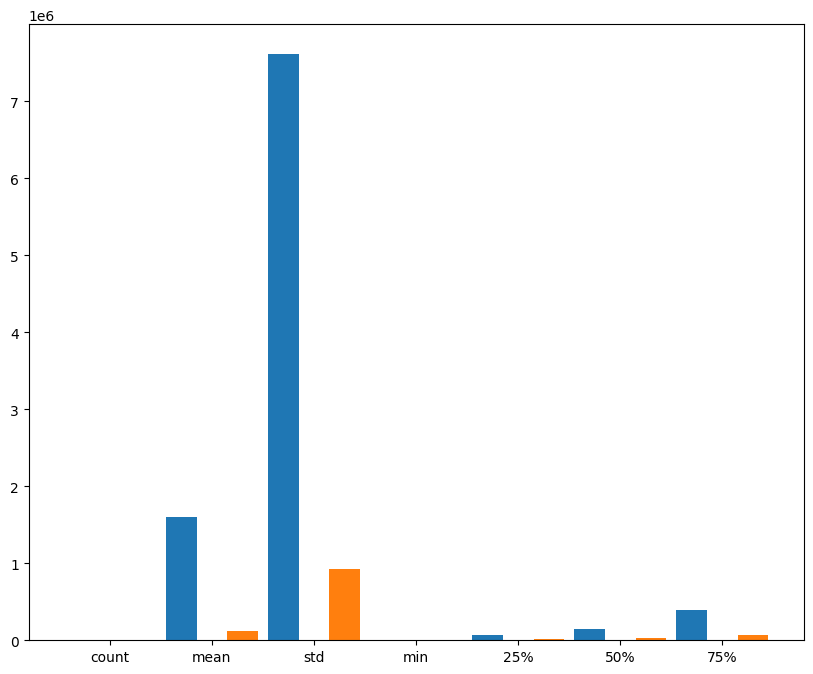

In [31]:
plt.figure(figsize=(10,8))
position = np.array(range(7))
width = 0.3
position_1 = position - width
position_2 = position + width
plt.bar(x=position_1, width=width, height=comparison_df.drop(columns=['max']).iloc[0])
plt.bar(x=position_2, width=width, height=comparison_df.drop(columns=['max']).iloc[1])
plt.xticks(ticks=position, labels=comparison_df.columns[0:7])